Integral Comparison 
=======================

Now that we have gotten a firm understandting of the PML and an understanding of how we can use NGSolve to implement and solve forward passes we may now compare the far-field that we get from a first order approximation and using a full far field transformation. We will first use a very similar test set-up to the 'Test Probem' with the only difference being a small $\eta(x)$ as that is required during the derivation.

In [1]:
%matplotlib notebook
from netgen.geom2d import SplineGeometry
from ngsolve import *
import matplotlib.pyplot as plt
import numpy as np
import math

geo = SplineGeometry()
geo.AddCircle( (0,0), 2.25, leftdomain=3, bc="outerbnd")
geo.AddCircle( (0,0), 1.75, leftdomain=2, rightdomain=3, bc="midbnd")
geo.AddCircle( (0,0), 1, leftdomain=1, rightdomain=2, bc="innerbnd")
geo.SetMaterial(1, "inner")
geo.SetMaterial(2, "mid")
geo.SetMaterial(3, "pmlregion")
mesh = Mesh(geo.GenerateMesh (maxh=0.1))
mesh.Curve(3)

mesh.SetPML(pml.Radial(rad=1.75,alpha=1j,origin=(0,0)), "pmlregion") #Alpha is the strenth of the PML.

omega_0 = 20
omega_tilde = 20.3 #-18.5*exp(-(x**2+y**2)) + 20 #70*exp(-(((x*x)*np.log(7/2))+((y*y)*np.log(7/2)))) #Gaussian function for our test Omega.

domain_values = {'inner': omega_tilde, 'mid': omega_0, 'pmlregion': omega_0}
values_list = [domain_values[mat] for mat in mesh.GetMaterials()]
omega = CoefficientFunction(values_list)

fes = H1(mesh, complex=True, order=5)

def forward_pass(theta):

    u_in =exp(1j*omega_0*(cos(theta)*x + sin(theta)*y)) #Can use any vector as long as it is on the unit circle. 

    #Defining our test and solution functions.
    u = fes.TrialFunction()
    v = fes.TestFunction()

    #Defining our LHS of the problem.
    a = BilinearForm(fes)
    a += grad(u)*grad(v)*dx - omega**2*u*v*dx
    a += -omega*1j*u*v * ds("innerbnd")
    a.Assemble()

    #Defining the RHS of our problem.
    f = LinearForm(fes)
    f += -u_in * (omega**2 - omega_0**2) * v * dx
    f.Assemble()

    #Solving our problem.
    u_s = GridFunction(fes, name="u")
    u_s.vec.data = a.mat.Inverse() * f.vec

    u_tot = u_in + u_s
    
    return [u_in, u_s, u_tot]

s = 1*np.pi

calc = forward_pass(s)
u_in = calc[0]
u_s = calc[1]
u_tot = calc[2]

ModuleNotFoundError: No module named 'netgen'

We first derive the integral form. The first steps of this derivation can be seen eariler in this work. We will skip to where we define $u^s(x)$ as an integral equation.

$$u^s(x) = \int_{\Omega} G_0(y-x)\eta(x)e^{i\omega\hat{s}\cdot x}\, dx\tag{3}$$

With $G_0$ being the integral kernel of Green functions of the free space Helmholtz operator, $L_0$. Doing so, as well as allowing $o(\eta(x))\to0$ as we are looking at $\eta(x)$ close to 0. We can now use the fundamental solution to the 2D Helmholtz equation to replace $G_0$. This is a Hankel equation of the first kind<sup>1</sup> which is an expansion of Bessel functions at infinity and are of the form:

$$G_0(z) = \dfrac{i}{4} H^{(1)}_0(z) = \left(\dfrac{2}{\pi \omega |z|}\right)^\frac{1}{2} \left(e^{iw|z|-i\frac{\pi}{4}}+o(1)\right)$$

Applying this to (3) and combining with equation (1), we can compute $\hat{u}^s(x)$

$$\hat{u}^s(x)=\lim_{\rho\to\infty} \sqrt{\rho} e^{-i\omega\rho} u^s(\rho\cdot\hat{r}) \approx \lim_{\rho\to\infty} \sqrt{\rho} e^{-i\omega\rho} \int_{\Omega} \left( \dfrac{i}{4} \sqrt{\left(\dfrac{2}{\pi \omega \rho}\right)} e^{-i\frac{\pi}{4}} e^{iw(\rho - \hat{r}\cdot x)} \eta(x) e^{-i\omega\hat{s}\cdot x}\right)\, dx$$

Grouping all the exponent terms and simplfying gives us 

$$= \dfrac{i}{4} \sqrt{\dfrac{2}{\pi \omega}} e^{-i\frac{\pi}{4}} \int_{\Omega} e^{-iw(\hat{r}-\hat{s})\cdot x} \eta(x)\, dx =: d_1(s,r)$$

$$= \dfrac{e^{\frac{\pi i}{4}}}{\sqrt{8\pi \omega}} \int_{\Omega} e^{-iw(\hat{r}-\hat{s})\cdot x} \eta(x)\, dx =: d_1(s,r)$$

With $d_1(s,r)$ denoting the first order approximation to $d(s,r)$ with respect to $\eta(x)$.

Similarly, to compute the full far-field transforation we use the formula from Chapter 3, equation $(3.64)$<sup>1</sup>.

$$u^s_{\infty}(\hat{r}) = \dfrac{e^{\frac{\pi i}{4}}}{\sqrt{8\pi \omega}} \int_{\partial\Omega}u(x)\dfrac{\partial e^{-i\omega\hat{r}\cdot x}}{\partial n} - \dfrac{\partial u(x)}{\partial n}e^{-i\omega\hat{r}\cdot x}\,dS(x)$$

<sup>1</sup>: "Inverse Acoustic and Electromagnetic Scattering Theory" by D. Colton et al.

In [2]:
def f1_field(r,s):
    
    temp = Integrate(exp(-1j*omega_0*((cos(r)-cos(s))*x+(sin(r)-sin(s))*y))*(omega**2 - omega_0**2),
              mesh,definedon=mesh.Materials("inner"))
    
    return (exp(1j*r)/np.sqrt(8*np.pi*omega_0))*temp

def ff_field(r):
    
    n = specialcf.normal(2)
    us_n = BoundaryFromVolumeCF(Grad(u_s)*n)
    ecomp = exp(-1j*omega_0*(cos(r)*x + sin(r)*y))
    ecomp_n = CoefficientFunction((ecomp.Diff(x),ecomp.Diff(y)))*n
    
    temp = Integrate(u_s*ecomp_n - us_n*ecomp, mesh,definedon=mesh.Boundaries("innerbnd"))
    
    return (exp(1j*r)/np.sqrt(8*np.pi*omega_0))*temp

r = np.pi

print("Full Comp:", abs(ff_field(r)), "\nFirst Order:", abs(f1_field(r,s)))

Full Comp: 1.6723840727418129 
First Order: 1.6941086733536286


<IPython.core.display.Javascript object>


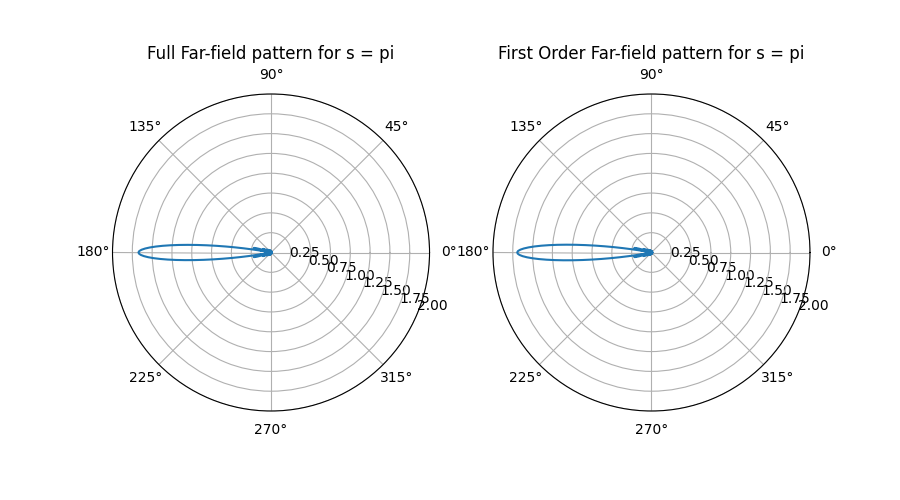

In [3]:
theta = np.arange(0, 2*np.pi, 0.01)

mag1 = []

mag2 = []

for r in theta:
    
    mag1.append(abs(ff_field(r)))
    
    mag2.append(abs(f1_field(r,s)))
    
d = np.pi
    
maxf = math.ceil(abs(ff_field(d)))

max1 = math.ceil(abs(f1_field(d,s)))

#print(maxf, max1)

    
fig = plt.figure(figsize=(9, 5))

ax = plt.subplot(1, 2, 1, projection='polar')

plt.title('Full Far-field pattern for s = pi')

ax.plot(theta, mag1)
ax.set_rmax(maxf)
#ax.set_rticks([0.1, .2, .3, 2, .4, .5])# Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax = plt.subplot(1, 2, 2, projection='polar')

plt.title('First Order Far-field pattern for s = pi')

ax.plot(theta, mag2)
ax.set_rmax(max1)
#ax.set_rticks([0.1, .2, .3, 2, .4, .5])# Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

plt.show()